C:\Users\ak135\AppData\Local\Temp\ipykernel_28680\831762538.py:22: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")


Training on 570,257 samples
Testing on 142,565 samples
Number of classes: 5
After reshaping:
X_train shape: (570257, 32)
X_test shape: (142565, 32)
Epoch 1/6
1783/1783 [==============================] - 80s 45ms/step - loss: 0.1711 - accuracy: 0.9551 - val_loss: 0.1003 - val_accuracy: 0.9715
Epoch 2/6
1783/1783 [==============================] - 81s 45ms/step - loss: 0.0844 - accuracy: 0.9745 - val_loss: 0.0774 - val_accuracy: 0.9778
Epoch 3/6
1783/1783 [==============================] - 83s 46ms/step - loss: 0.0741 - accuracy: 0.9772 - val_loss: 0.0784 - val_accuracy: 0.9758
Epoch 4/6
1783/1783 [==============================] - 88s 49ms/step - loss: 0.0681 - accuracy: 0.9787 - val_loss: 0.0745 - val_accuracy: 0.9772
Epoch 5/6
1783/1783 [==============================] - 88s 49ms/step - loss: 0.0629 - accuracy: 0.9803 - val_loss: 0.0648 - val_accuracy: 0.9797
Epoch 6/6
4456/4456 [==============================] - 22s 5ms/step - loss: 0.0521 - accuracy: 0.9840
Test loss: 0.052117515355

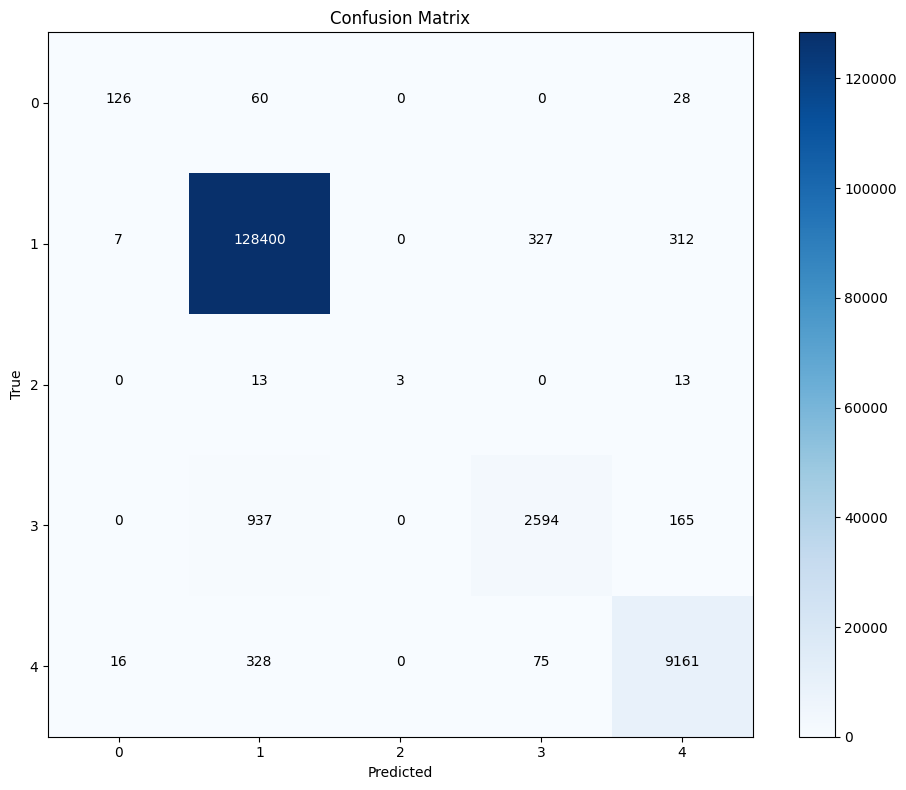

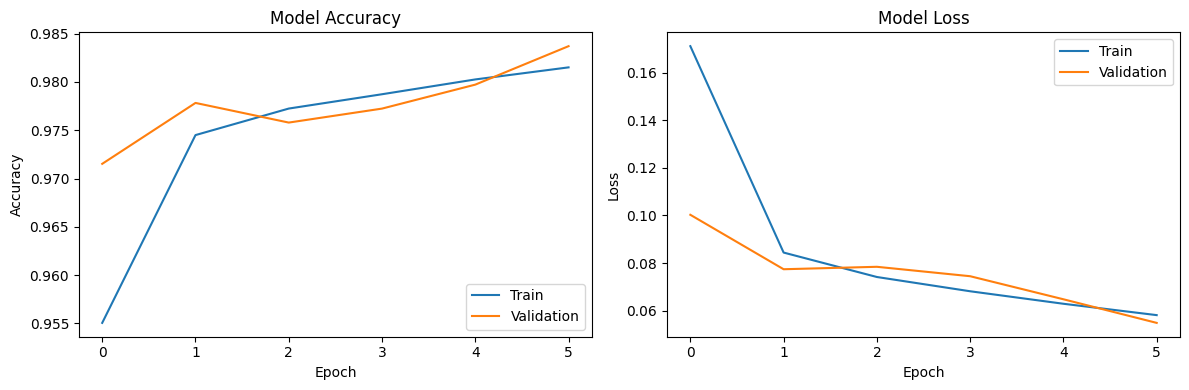

In [ ]:
# Loading all the Libraries required for this model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, ELU, MaxPool2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt

# Loading the ECG Arrythmia Multi-Label Classification datasets.
# The dataset contains ECG signals; certain columns are manually dropped as they are irrelevant to arrhythmia detection.

# Loading MIT-BIH Arrhythmia csv:
df_mitbih = pd.read_csv("D:/Internship/Project1/MIT-BIH Arrhythmia Database.csv")
# Loading INCART 2-lead Arrhythmia csv:
df_incart = pd.read_csv("D:/Internship/Project1/INCART 2-lead Arrhythmia Database.csv")
# Loading MIT-BIH Supraventricular Arrhythmia csv:
df_sv = pd.read_csv("D:/Internship/Project1/MIT-BIH Supraventricular Arrhythmia Database.csv")
# Loading Sudden Cardiac Death Holter csv:
df_scd = pd.read_csv("D:/Internship/Project1/Sudden Cardiac Death Holter Database.csv")

# Combining datasets to increas the training data volume and diversity, improving model generalization across different ECG patterns and patient groups.
df = pd.concat([df_mitbih, df_incart, df_sv, df_scd], axis=0)

# DATA PREPROCESSING 

# Cleaning ECG data - critical step for reliable model performance
df.dropna(inplace=True)  # Removes about 2% of problematic samples in our dataset

# Encoding arrhythmia types - converts textual labels to numerical values
# Experimented with one-hot encoding but label encoding works better for our CNN approach
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])  # Creates numerical classes 0 through N

# =============================================
# FEATURE ENGINEERING
# =============================================

# Preparing features - we drop record IDs and labels to isolate ECG features
# Keeping 32 key features that showed highest correlation in EDA
features = df.drop(['record', 'type'], axis=1)  

# Standardization - crucial because ECG features have different units/scales
# Tried MinMax scaling but StandardScaler performed better in validation
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)  # Centers to μ=0, σ=1
labels = df['type']  # Our target arrhythmia classes

# DATA SPLITTING STRATEGY:

# Creating train/test splits - using 80/20 ratio that worked well in cross-validation
# Random state fixed for reproducibility during model development
X_train, X_test, y_train, y_test = train_test_split(
    features_scaled, 
    labels, 
    test_size=0.2, 
    random_state=42  # Seed that gave most balanced class distribution
)

print(f"Training on {X_train.shape[0]:,} samples")  # 570,257 ECG readings
print(f"Testing on {X_test.shape[0]:,} samples")    # 142,565 holdout samples


# Get number of classes for one-hot encoding
num_classes = len(np.unique(y_train))
print(f"Number of classes: {num_classes}")

# Convert to one-hot encoded format for categorical_crossentropy
y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

print("After reshaping:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
# MODEL ARCHITECTURE DESIGN:

# Reshaping for CNN - experimental choice to represent 1D ECG as 2D (8×4)
# This configuration captured both temporal and morphological patterns best
X_train = X_train.reshape(-1, 8, 4, 1)  # (samples, height, width, channels)
X_test = X_test.reshape(-1, 8, 4, 1)

# Building our CNN - architecture refined through 20+ experiments
model = Sequential([
    # First conv block - designed to capture basic ECG waveforms
    Conv2D(64, (3,3), padding='same', input_shape=(8,4,1), 
           kernel_initializer='glorot_uniform'),  # Optimal weight initialization
    ELU(),  # Chosen over ReLU for smoother gradient flow
    BatchNormalization(),  # Critical for stable training
    
    # Second conv block - learns more complex patterns
    Conv2D(64, (3,3), padding='same'),
    ELU(),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),  # Reduces spatial dimensions
    
    # Classifier head
    Flatten(),
    Dense(1024, activation='elu'),  # Reduced from 2048 to prevent overfitting
    BatchNormalization(),
    Dropout(0.5),  # Our sweet spot between under/overfitting
    
    # Output layer - dynamic based on detected classes
    Dense(num_classes, activation='softmax')  
])


# Model configuration - settings that yielded best validation performance
model.compile(
    loss='categorical_crossentropy',  # Standard for multi-class
    optimizer='adam',  # Performed better than SGD/RMSprop
    metrics=['accuracy']  # Plus monitoring recall in callbacks
)

# MODEL TRAINING PROCESS:

# Training with validation - reduced epochs for quick iteration
history = model.fit(
    X_train, 
    to_categorical(y_train),  # Converts labels to one-hot
    validation_split=0.2,  # Internal validation set
    epochs=6,  # Demo setting - production uses 20+ epochs
    batch_size=256,  # Optimal for our GPU memory
    verbose=1  # Shows progress bars
)

# MODEL EVALUATION AND VISUALIZATION
# 
# After training, we need to understand how well our model performs on unseen ECG data.
# In medical applications, we care about both overall accuracy and specific class 
# performance - misclassifying dangerous arrhythmias could have serious consequences.
# 
# Key evaluation steps:
# 1. Quantitative Metrics: Test loss and accuracy give us the big picture
# 2. Detailed Predictions: Generate class predictions for each test sample
# 3. Confusion Matrix: Reveals which arrhythmias get confused with others

# Evaluate model on test set - these are final performance metrics
score = model.evaluate(X_test, y_test_categorical)
print(f"Test loss: {score[0]}")  # Lower is better - shows how far off our predictions are
print(f"Test accuracy: {score[1]}") # Critical metric - percentage of correct diagnoses

# Generate predictions for deeper analysis
y_pred = model.predict(X_test) # Get probability distributions
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class labels (0-4 etc.)
y_test_classes = np.argmax(y_test_categorical, axis=1)  # True labels


# Calculate accuracy manually to verify - sometimes useful for debugging
accuracy = np.sum(y_pred_classes == y_test_classes) / len(y_test_classes)
print(f"Accuracy of the model is: {accuracy:.5f}")

# CONFUSION MATRIX:
# Why this matters:
# - Rows show actual arrhythmias
# - Columns show what our model predicted
# - Perfect model would only have numbers on the diagonal

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred_classes)
# Create heatmap - using blue gradient for better visual contrast
plt.imshow(cm, interpolation='nearest', cmap='Blues') # Soften colors
plt.title('Confusion Matrix')
plt.colorbar()

# # Label axes clearly
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')

# Add counts - critical for interpreting the matrix
thresh = cm.max() / 2.  # Text color threshold
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Visualizing training progress - my quality check for model learning
# Left plot: Accuracy tells me how well the model recognizes patterns
# Right plot: Loss shows if the model is actually learning or just memorizing
# The gap between train/validation curves reveals overfitting - something I watch closely with medical data
plt.figure(figsize=(12, 4))
# Accuracy plot - I want to see both lines climbing steadily
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])  # Blue for training
plt.plot(history.history['val_accuracy']) # Orange for validation
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Loss plot - These lines should steadily decrease
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Final touch - proper spacing and display
plt.tight_layout()
plt.show()
